# **Motorbike Ambulance Calls**


**Регресія**

Прогнозування погодинної кількості викликів швидкої допомоги з урахуванням природних та сезонних умов. Модель прогнозування повинна враховувати монотонність за деякими ознаками, якщо це підтверджується даними.

**Виявлення подій та аномалій**

Визначити моделі викликів швидкої допомоги щодо особливих подій та визначити випадки, які можна вважати ненормальною поведінкою.  

**Результати**

Повнотекстовий звіт, що містить детальний опис процесів аналізу даних, моделювання даних та виявлення закономірностей/аномалій з висновками та їх поясненнями.


## **Опис даних:**

---



Набір `motorbike_ambulance_calls.csv` містить наступні атрибути:

              - index: record index
              - date : date
              - season : season (1:springer, 2:summer, 3:fall, 4:winter)
              - yr : year (0: 2011, 1:2012)
              - mnth : month ( 1 to 12)
              - hr : hour (0 to 23)
              - holiday : whether day is holiday or not
              - weekday : day of the week
              - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
              -  weathersit :
                      - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                      - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                      - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                      - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
              - temp : Normalized temperature in Celsius. The values are divided to 41 (max)
              - atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
              - hum: Normalized humidity. The values are divided to 100 (max)
              - windspeed: Normalized wind speed. The values are divided to 67 (max)
              - cnt: count of total ambulance calls (Це наш цільовий атрибут)


##Import libraries & downloading data

In [83]:
import pandas as pd
import numpy as np
import scipy as sc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [84]:
dataset = pd.read_csv("motorbike_ambulance_calls.csv")
dataset[4250:4260]

,index,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
4250,4251,7/1/11,autumn,0,7,0,0,5,1,1,0.66,0.6212,0.50,0.0000,68
4251,4252,7/1/11,autumn,0,7,1,0,5,1,1,0.66,0.6212,0.50,0.0000,31
4252,4253,7/1/11,autumn,0,7,2,0,5,1,1,0.62,0.6061,0.69,0.0000,13
4253,4254,7/1/11,autumn,0,7,3,0,5,1,1,0.64,0.6212,0.53,0.0000,11
4254,4255,7/1/11,autumn,0,7,4,0,5,1,1,0.62,0.6212,0.57,0.0000,6
4255,4256,7/1/11,autumn,0,7,5,0,5,1,1,0.60,0.6061,0.64,0.1343,30
4256,4257,7/1/11,autumn,0,7,6,0,5,1,1,0.62,0.6061,0.61,0.1343,108
4257,4258,7/1/11,autumn,0,7,7,0,5,1,1,0.66,0.6212,0.54,0.1045,243
4258,4259,7/1/11,autumn,0,7,8,0,5,1,1,0.70,0.6364,0.42,0.1642,492
4259,4260,7/1/11,autumn,0,7,9,0,5,1,1,0.74,0.6515,0.35,0.1642,260


In [61]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       17379 non-null  int64  
 1   date        17379 non-null  object 
 2   season      17379 non-null  object 
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  cnt         17379 non-null  int64  
dtypes: float64(4), int64(9), object(2)
memory usage: 2.0+ MB


In [62]:
dataset.isnull().sum()

index         0
date          0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

In [86]:
#приведемо дату до числового значення замість стрічки
dataset['date'] = pd.to_datetime(dataset['date'])
dataset['timestamp'] = dataset['date'].astype('int64') // 10**9

#також закодуємо пори року в числа
category_mapping = {'winter': 3, 'spring': 1, 'autumn': 4, 'summer': 2}
dataset['season']  = dataset['season'].map(category_mapping)

In [87]:
dataset.describe()


,index,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,timestamp
count,17379.0000,17379,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,1.737900e+04
mean,8690.0000,2012-01-02 04:08:34.552045568,2.516831,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,189.463088,1.325477e+09
min,1.0000,2011-01-01 00:00:00,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000,1.293840e+09
25%,4345.5000,2011-07-04 00:00:00,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,40.000000,1.309738e+09
50%,8690.0000,2012-01-02 00:00:00,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000,1.325462e+09
75%,13034.5000,2012-07-02 00:00:00,4.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,281.000000,1.341187e+09
max,17379.0000,2012-12-31 00:00:00,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000,1.356912e+09
std,5017.0295,NaN,1.120433,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,181.387599,1.815023e+07


#categorical variables: yr, holiday, weekday, workingday, 


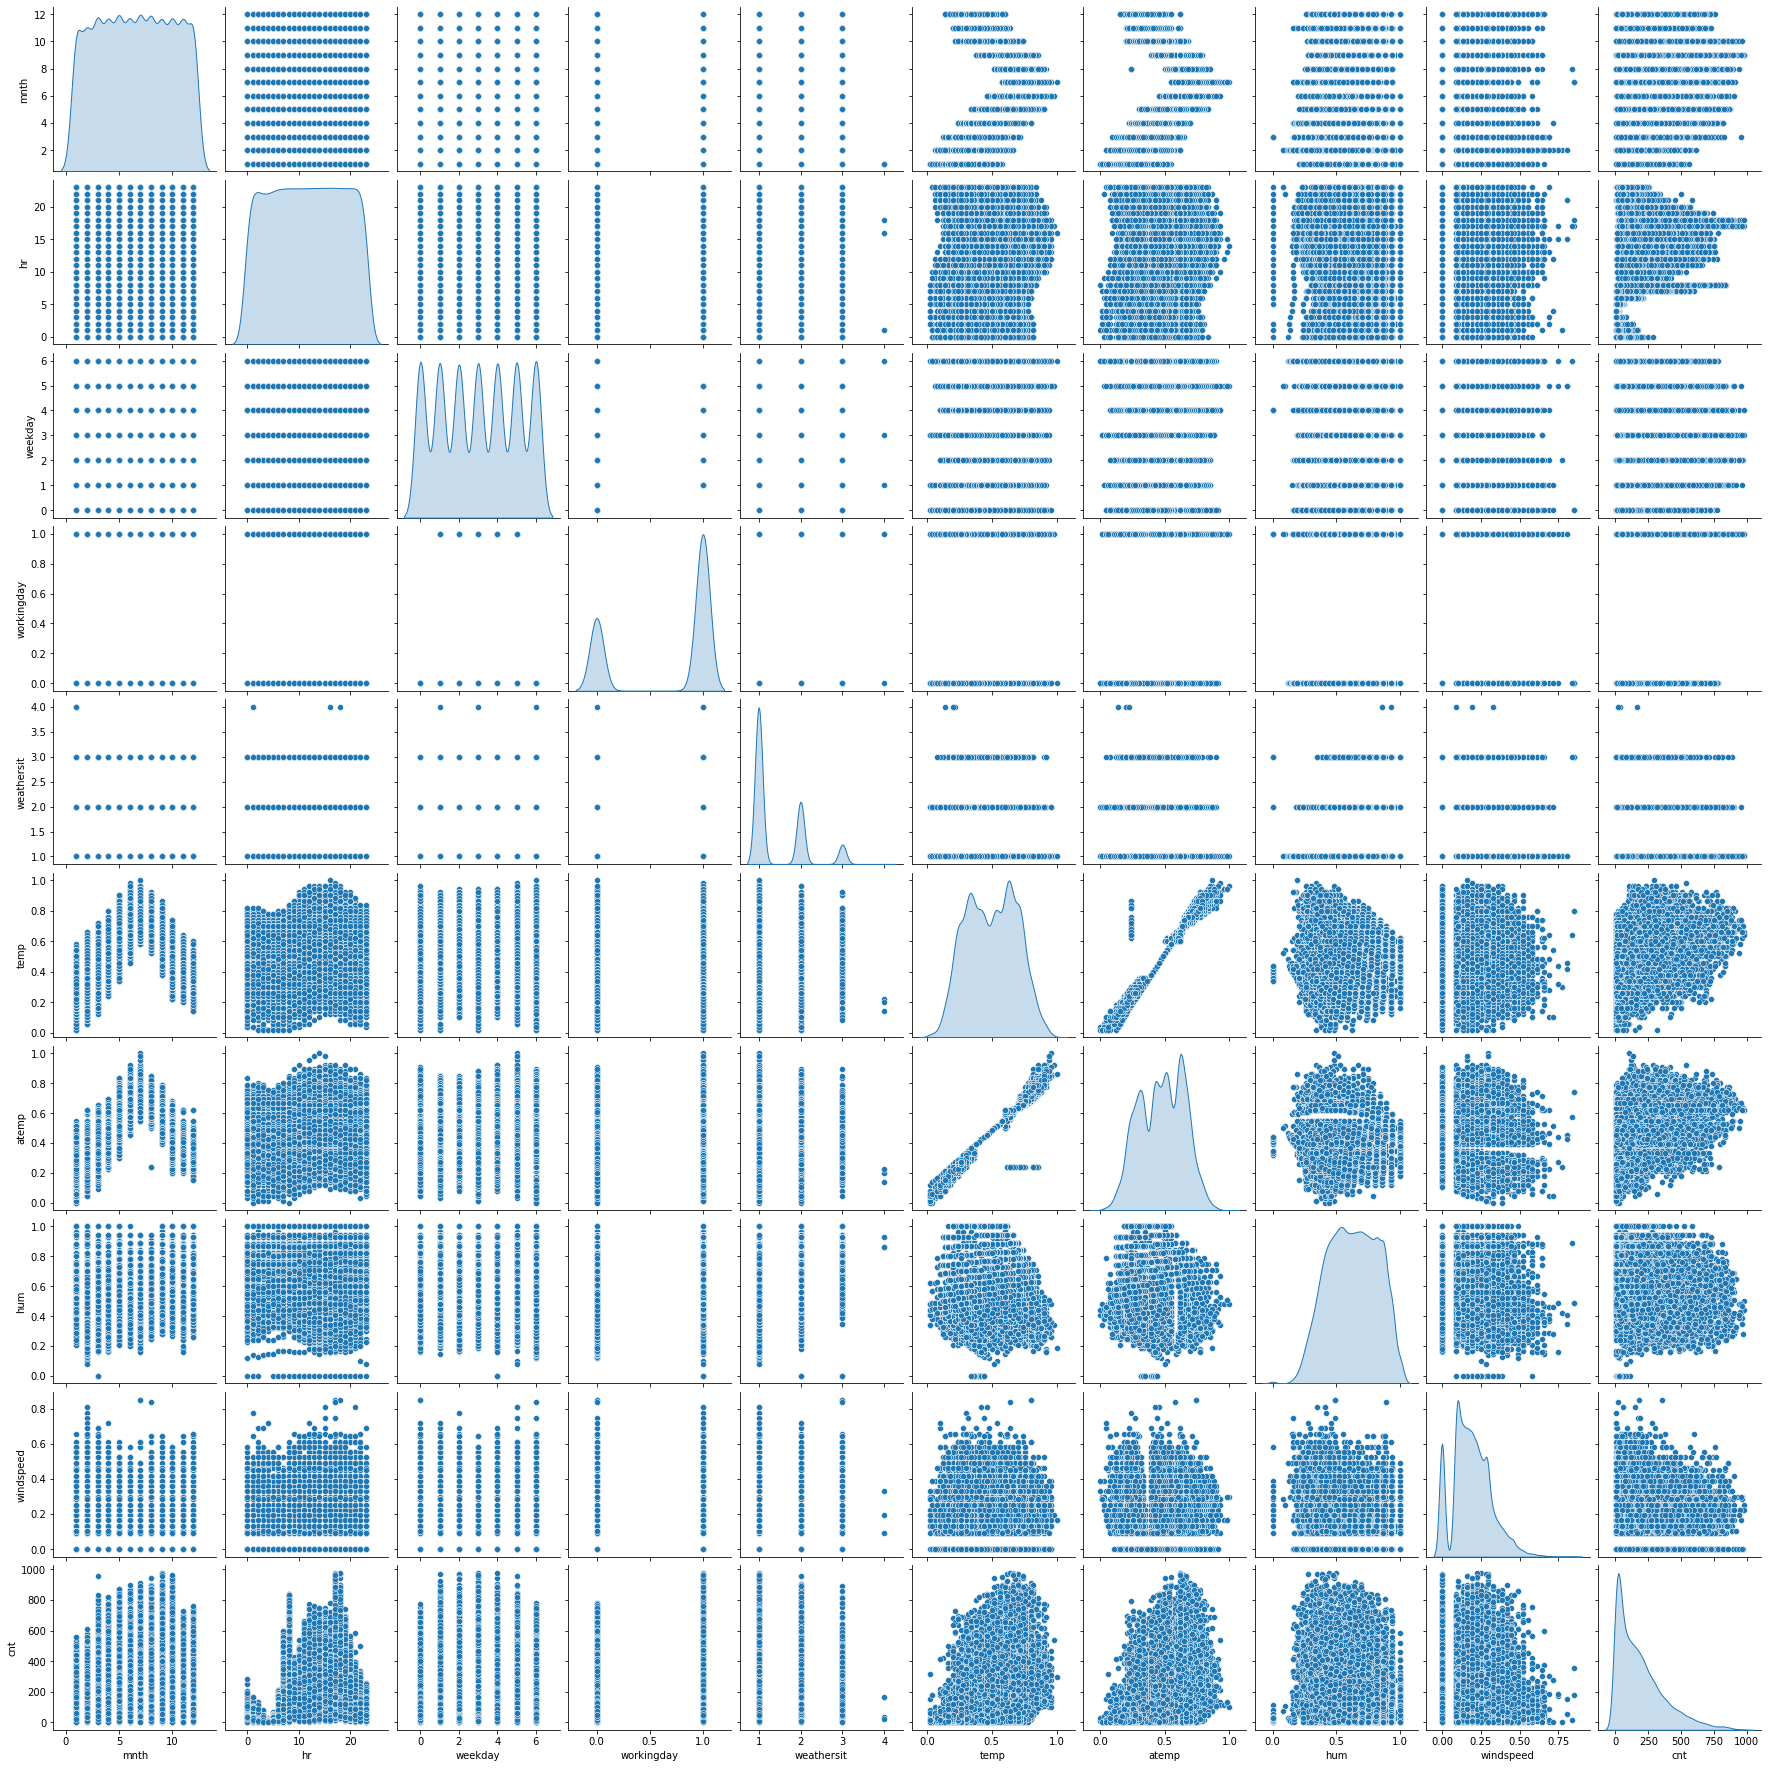

In [65]:
numerical =dataset[['mnth','hr', 'weekday', 'workingday','weathersit', 'temp', 'atemp', 'hum','windspeed', 'cnt']]
sns.pairplot(numerical, diag_kind='kde')
plt.show()

In [88]:
dataset

,index,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,timestamp
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16,1293840000
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40,1293840000
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32,1293840000
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13,1293840000
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1,1293840000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,119,1356912000
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,89,1356912000
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,90,1356912000
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,61,1356912000


In [67]:
dataset.groupby('season').count()

,index,date,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,timestamp
season,,,,,,,,,,,,,,,
1,4242,4242,4242,4242,4242,4242,4242,4242,4242,4242,4242,4242,4242,4242,4242
2,4409,4409,4409,4409,4409,4409,4409,4409,4409,4409,4409,4409,4409,4409,4409
3,4232,4232,4232,4232,4232,4232,4232,4232,4232,4232,4232,4232,4232,4232,4232
4,4496,4496,4496,4496,4496,4496,4496,4496,4496,4496,4496,4496,4496,4496,4496


<Axes: >

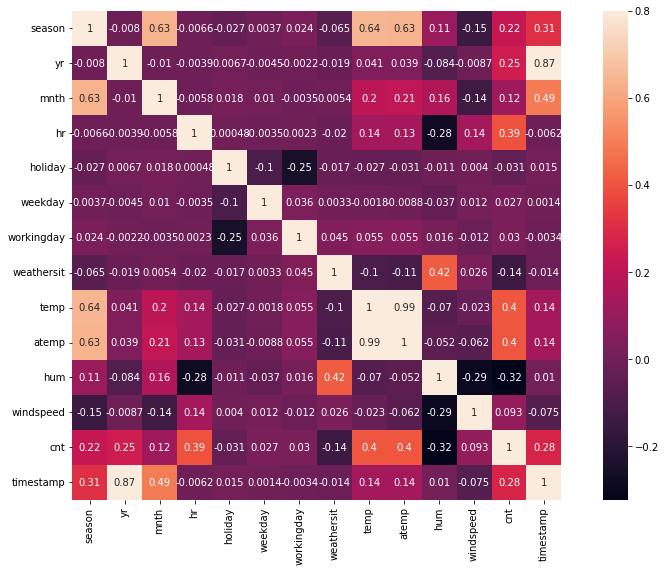

In [68]:
corrmat = dataset[dataset.columns[2:]].corr()
f, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)
#

Колонки month, yr, mnth,HR,weathersit, TEMP, ATEMP, HUM, windspeed, season_new мають помітну кореляцію з цільовою змінною. А колонки holiday, weekday, workingday мають малу кореляцію з кількістю викликів швидкої, тому було прийняте рішення видалити 2 останніх, залишимо лише holiday, щоб все ж була прив'язка до дня.

## Anomaly detection

In [69]:
np.sum(dataset["hum"] == 0)

22

Вологість повітря за своєю природою не може бути рівна 0, тому це просто пропущені дані. Заповнимо їх середнім арифметичним по всіх інших колонках

In [79]:
dataset[dataset['hum'] == 0] = dataset.hum.mean()
np.sum(dataset["hum"] == 0)

0

In [71]:
np.sum(dataset["windspeed"] == 0)


2180

Також по графіках, наведених вище, бачимо, що параметр вітру має теж аномальні нулі. Швидкість вітру, звісно, не мусить бути більша 0,але на графіках видно чіткий пробіл між нульовими значеннями швидкості вітру і іншими. Тому можемо припустити, що перед занесенням в таблцю значення, які були досить малі, позначались 0. Так роблять при спостереженні за погодою, і такі дані можуть бути присутні в незнайомому для моделі датасеті, до чого вона має бути готова. Тим більше, нульових значень там більше 2 тис, що становить велику частину датасету. Враховуючи ці причини, модифікувати цей стовпець ми не будемо

### Data normalization

In [78]:
min_value = dataset['timestamp'].min()
max_value = dataset['timestamp'].max()

dataset['Normalized_time'] = (dataset['timestamp'] - min_value) / (max_value - min_value)
dataset['Normalized_time']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
17374    1.0
17375    1.0
17376    1.0
17377    1.0
17378    1.0
Name: Normalized_time, Length: 17379, dtype: float64

## Interquartile Range

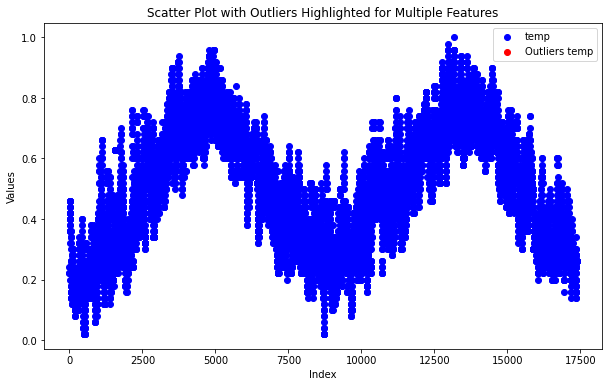

In [33]:

# Calculate quartiles for each feature
data_to_analyze = dataset[['temp', 'atemp']]

Q1 = data_to_analyze.quantile(0.25)
Q3 = data_to_analyze.quantile(0.75)

# Calculate IQR for each feature
IQR = Q3 - Q1

# Define outlier thresholds for each feature
threshold = 1.5
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

# Identify outliers for each feature
outliers = ((data_to_analyze < lower_bound) | (data_to_analyze > upper_bound)).any(axis=1)

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(data_to_analyze.index, data_to_analyze['temp'], color='blue', label='temp')
#plt.scatter(data_to_analyze.index, data_to_analyze['atemp'], color='green', label='atemp')
plt.scatter(data_to_analyze.index[outliers], data_to_analyze['temp'][outliers], color='red', label='Outliers temp')
#plt.scatter(data_to_analyze.index[outliers], data_to_analyze['atemp'][outliers], color='orange', label='Outliers Feature2')
plt.title('Scatter Plot with Outliers Highlighted for Multiple Features')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

In [80]:
dataset.describe()

,index,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,timestamp,Normalized_time
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,1.737900e+04,17379.000000
mean,8688.022832,2.516359,0.503355,6.534772,11.532067,0.029564,2.999413,0.682249,1.422395,0.497289,0.476081,0.628023,0.190560,189.428034,1.323832e+09,0.502282
std,5020.144963,1.121150,0.499707,3.442899,6.921057,0.168511,2.007235,0.465298,0.637717,0.192569,0.171897,0.191633,0.123249,181.419003,5.049803e+07,0.287437
min,0.627229,0.627229,0.000000,0.627229,0.000000,0.000000,0.000000,0.000000,0.627229,0.020000,0.000000,0.080000,0.000000,0.627229,6.272288e-01,0.000000
25%,4345.500000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,40.000000,1.309738e+09,0.253425
50%,8690.000000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000,1.325462e+09,0.502740
75%,13034.500000,4.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,281.000000,1.341187e+09,0.750685
max,17379.000000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000,1.356912e+09,1.000000


## Кодуємо категоріальні змінні за допомогою One-hot encoder

In [95]:
dataset.describe()

,season,yr,mnth,hr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.516831,0.502561,6.537775,11.546752,0.028770,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,189.463088
std,1.120433,0.500008,3.438776,6.914405,0.167165,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,4.000000,1.000000,10.000000,18.000000,0.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


In [94]:
dataset = dataset.drop(['timestamp', 'weekday', 'index', 'date'], axis = 1)
df_encoded = pd.get_dummies(data=dataset, columns=['weathersit', 'mnth', 'season'])
df_encoded

,yr,hr,holiday,workingday,temp,atemp,hum,windspeed,cnt,weathersit_1,...,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,season_1,season_2,season_3,season_4
0,0,0,0,0,0.24,0.2879,0.81,0.0000,16,True,...,False,False,False,False,False,False,True,False,False,False
1,0,1,0,0,0.22,0.2727,0.80,0.0000,40,True,...,False,False,False,False,False,False,True,False,False,False
2,0,2,0,0,0.22,0.2727,0.80,0.0000,32,True,...,False,False,False,False,False,False,True,False,False,False
3,0,3,0,0,0.24,0.2879,0.75,0.0000,13,True,...,False,False,False,False,False,False,True,False,False,False
4,0,4,0,0,0.24,0.2879,0.75,0.0000,1,True,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,19,0,1,0.26,0.2576,0.60,0.1642,119,False,...,False,False,False,False,False,True,True,False,False,False
17375,1,20,0,1,0.26,0.2576,0.60,0.1642,89,False,...,False,False,False,False,False,True,True,False,False,False
17376,1,21,0,1,0.26,0.2576,0.60,0.1642,90,True,...,False,False,False,False,False,True,True,False,False,False
17377,1,22,0,1,0.26,0.2727,0.56,0.1343,61,True,...,False,False,False,False,False,True,True,False,False,False


In [98]:
y = df_encoded['cnt']
X = df_encoded.drop('cnt', axis = 1)

# Лінійна регресія

In [100]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print("TRAIN")
print("Mean Squared Error:", mse) # -> 0
print("R-squared:", r2)  # -> 1

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("TEST")
print("Mean Squared Error:", mse) # -> 0
print("R-squared:", r2)  # -> 1


TRAIN
Mean Squared Error: 19729.443483266725
R-squared: 0.40577410577115913
TEST
Mean Squared Error: 18748.999686462248
R-squared: 0.40790285377166957


На тестовому наборі маємо Mean Squared Error  18748.9, вона має бути якомога меншою для покращення моделі. А R-squared маємо 0.407, в ідеальній моделі ця метрика була б 1. 
Отже, ми побудували модель лінійної регресії, перед чим проаналізували датасет, виправили аномалії, закодували категоризаційні змінні, нормалізували числові. Модель можна було б покращити шляхом збільшення кількості прикладів, або ж наприклад, видаливши аномалії з датасету, але тоді дані були б частково штучними і не правдоподібними, через що при передачі реальних даних для передбачення модель могла би гірше справлятися. Тому змінювати початкові дані потрібно з обережністю.